In [49]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

# outdir = "/media/hieunguyen/HNSD_mini/outdir"
outdir = "/media/hieunguyen/GSHD_HN01/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6
mode = "all"
selected_candi_features = "ratio_raw"
input_cancer_class = "Liver"

path_to_main_output = os.path.join(outdir, PROJECT, output_version)
if mode == "all":
    path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
    path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
    path_to_12_output = os.path.join(outdir, PROJECT, output_version, "12_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
elif mode == "hypo_only":
    path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
    path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
elif mode == "hyper_only":
    path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
    path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))

path_to_tf_output = os.path.join(outdir, PROJECT, output_version, "TF_output")
path_to_01_tf_output = os.path.join(path_to_tf_output, "01_output")

metadata = pd.read_excel("metadata_cfDNA_lowpdepth_TMD_bam_cov.xlsx")
metadata = metadata[metadata["Label"].isin([input_cancer_class, "Control"])]

candidf = pd.read_excel(os.path.join(path_to_08_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)))
candidf = candidf[["SampleID", "Label", selected_candi_features]]
ichorcnadf = pd.read_excel("./ichorCNA/metadata_cfDNA_lowpdepth.xlsx")

# keep only samples that have ichorCNA tumor fractions. 
ichorcnadf = ichorcnadf[(ichorcnadf["SampleID"].isin(candidf["SampleID"].unique())) & 
                        (ichorcnadf["ichorCNA"].isna() == False)][["SampleID", "ichorCNA"]]

tf_sampledf = pd.read_csv("./ichorCNA/analytical_LOD_TF.csv")
tf_sampledf['Label'] = tf_sampledf["LABEL"].apply(lambda x: "CRC" if x == "Colorectal cancer" else x.split(" ")[0])
tf_sampledf["SampleID"] = tf_sampledf["Sample"].values
tf_sampledf = tf_sampledf[tf_sampledf["Label"].isin(["Control", input_cancer_class])]
tf_candi_sampledf = pd.read_excel(os.path.join(path_to_12_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)))

tf_maindf = tf_sampledf[["SampleID", "Label", "Actual tumor_fraction_ichorCNA", "Simulated TF",	"spike-in"]].merge(tf_candi_sampledf[["SampleID", selected_candi_features]], right_on = "SampleID", left_on = "SampleID")
tf_maindf.columns = ["SampleID", "Label", "ichorCNA", "simulated_TF", "spike_in", selected_candi_features]
tf_maindf["spike_in_label"] = tf_maindf["simulated_TF"].apply(lambda x: "Control" if x == "Healthy-control" else input_cancer_class)
convert_ratio = {
    '50' : 0.5, 
    '100': 1, 
    '0.5': 0.005, 
    '25': 0.25, 
    '15': 0.15, 
    '5': 0.5, 
    '1': 1, 
    'HC': 0
}
tf_maindf["spike_in_ratio"] = tf_maindf["spike_in"].apply(lambda x: convert_ratio[x])
maindf = candidf.merge(ichorcnadf, right_on = "SampleID", left_on = "SampleID")



<Axes: xlabel='ratio_raw', ylabel='ichorCNA'>

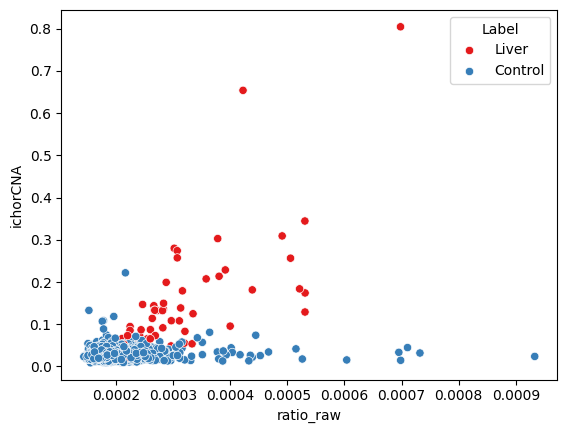

In [57]:
maindf['Label'] = pd.Categorical(maindf['Label'], categories=[input_cancer_class, "Control"])
sns.scatterplot(data = maindf, x = selected_candi_features, y = "ichorCNA", hue = "Label", palette = "Set1")

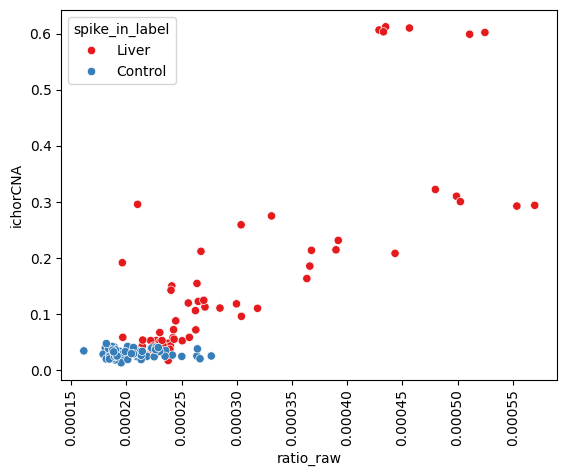

In [60]:
sns.scatterplot(data = tf_maindf, x = selected_candi_features, y = "ichorCNA", hue = "spike_in_label", palette = "Set1")
plt.xticks(rotation = 90)
plt.show()

Mean Squared Error: 0.05920924979914307
R^2 Score: 0.564445668869904


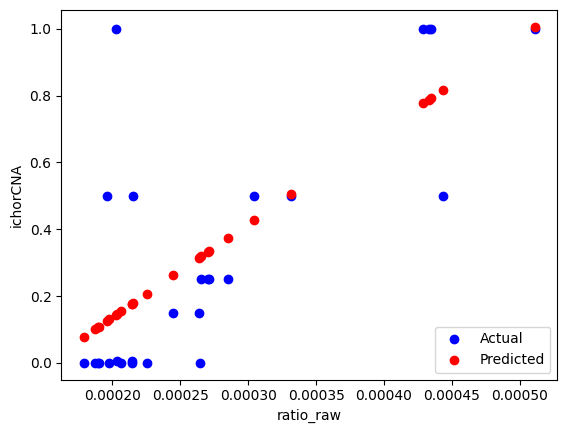

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target variable
X = tf_maindf[[selected_candi_features]]
y = tf_maindf["spike_in_ratio"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel(selected_candi_features)
plt.ylabel('ichorCNA')
plt.legend()
plt.show()

Mean Squared Error: 0.07424122117296511
R^2 Score: 0.4538676720281578


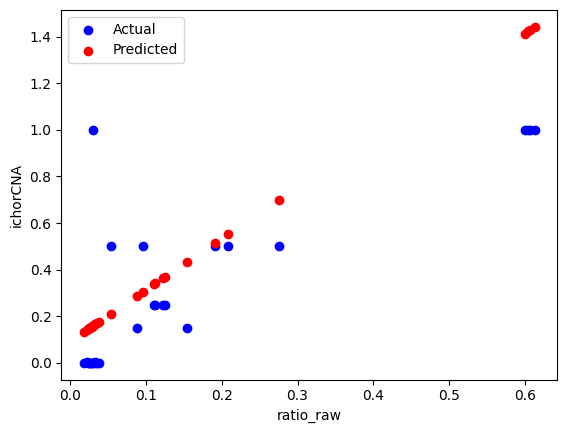

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target variable
X = tf_maindf[["ichorCNA"]]
y = tf_maindf["spike_in_ratio"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel(selected_candi_features)
plt.ylabel('ichorCNA')
plt.legend()
plt.show()

Mean Squared Error: 0.05449874421809169
R^2 Score: 0.5990970301791485


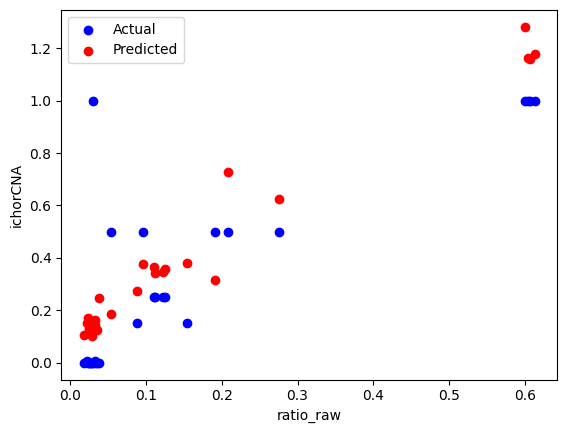

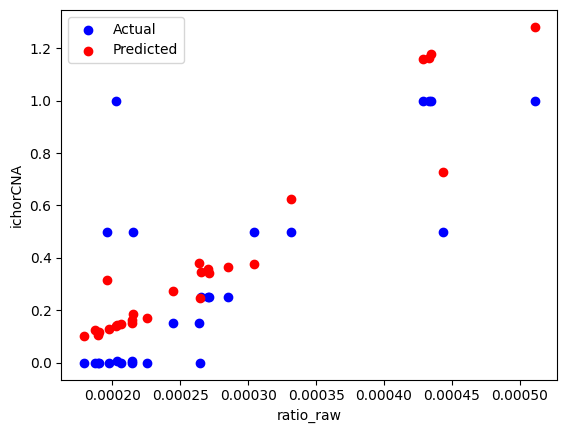

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target variable
X = tf_maindf[["ichorCNA", selected_candi_features]]
y = tf_maindf["spike_in_ratio"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the results
plt.scatter(X_test["ichorCNA"], y_test, color='blue', label='Actual')
plt.scatter(X_test["ichorCNA"], y_pred, color='red', label='Predicted')
plt.xlabel(selected_candi_features)
plt.ylabel('ichorCNA')
plt.legend()
plt.show()

plt.scatter(X_test[selected_candi_features], y_test, color='blue', label='Actual')
plt.scatter(X_test[selected_candi_features], y_pred, color='red', label='Predicted')
plt.xlabel(selected_candi_features)
plt.ylabel('ichorCNA')
plt.legend()
plt.show()